In [8]:
%matplotlib inline
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import plotly.graph_objs as go
import calmap
import folium
import plotly.express as px
import datetime as dt
# color pallette
c = '#393e46' # confirmed - grey
d = '#ff2e63' # death - red
r = '#30e3ca' # recovered - cyan
s = '#f8b400' # toujours infecté - yellow

cdr = [c, d, r] 
idr = [s, d, r] 
rid = [r, s, d]

In [68]:
df1 = pd.read_csv('C:/Users/KONLAMBIGUE DJOUMA/Projet deeplearning/Coronavirus/Covid19_data/Covid19.csv')
df1=df1[['Province/State','Lat','Long']]
df = pd.read_csv('C:/Users/KONLAMBIGUE DJOUMA/Projet deeplearning/Coronavirus/Covid19_data/covid_19_data.csv')
df = df.rename(columns = {'ObservationDate':'Date'})               
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'toujours infecté']

# toujours infecté = confirmed - deaths - recovered
df['toujours infecté'] = df['Confirmed'] - df['Deaths'] - df['Recovered']

# replacing Mainland china with just China
df['Country/Region'] = df['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
df[['Province/State']] = df[['Province/State']].fillna('')
df[cases] = df[cases].fillna(0)
df=pd.merge(df, df1, right_index=True, left_index=True)
df = df.rename(columns = {'Province/State_x':'Province/State'}) 

In [69]:
df_france=df.loc[df['Country/Region'] == 'France']
temp = df_france.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered','toujours infecté']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
temp.loc[mask, 'toujours infecté'] = np.nan

fig = px.bar(temp, x="Date", y="toujours infecté", color='Country/Region',
             title='Nombre de cas en france par jour')
fig.write_html("Nombre_de_cas_par_jours_france.html")

fig = px.bar(temp, x="Date", y="Deaths", color='Country/Region',
             title='Nombre de personne décédé en france par jour')
fig.write_html("Nombre_de_cas_Deaths_par_jours_france.html")

fig = px.bar(temp, x="Date", y="Recovered", color='Country/Region',
             title='Nombre de personne guéri en france par jour')
fig.write_html("Nombre_de_cas_Recovered_par_jours_france.html")

In [70]:
# cases in the ships
ship = df[df['Province/State'].str.lower().str.contains('ship')]

# china and the row
china = df[df['Country/Region']=='China']
row = df[df['Country/Region']!='China']

# latest
full_latest = df[df['Date'] == max(df['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
row_latest = full_latest[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Date','Confirmed', 'Deaths', 'Recovered', 'toujours infecté'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'toujours infecté'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'toujours infecté'].sum().reset_index()

In [71]:
temp = df.groupby('Date')['Recovered'].sum().reset_index()
temp = temp.melt(id_vars="Date", value_vars=['Recovered'],
                 var_name='Case', value_name='Count')
temp.head()

fig = px.area(temp, x="Date", y="Count", color='Case'
             )
fig.update_layout(xaxis_rangeslider_visible=True)
fig.write_html("ConfirmedLine.html")

In [72]:

fig = px.choropleth(full_latest_grouped, locations="Country/Region", 
                    locationmode='country names', color=np.log(full_latest_grouped["Confirmed"]), 
                    hover_name="Country/Region", hover_data=['Confirmed'],
                    color_continuous_scale="Sunsetdark", 
                    title='Cas confirmé par pays')
fig.update(layout_coloraxis_showscale=False)
fig.write_html("Confirmedmap.html")

In [73]:
temp = full_latest_grouped[full_latest_grouped['Deaths']>0]
fig = px.choropleth(temp, 
                    locations="Country/Region", locationmode='country names',
                    color=np.log(temp["Deaths"]), hover_name="Country/Region", 
                    color_continuous_scale="Peach", hover_data=['Deaths'],
                    title='Décès reportés par pays')
fig.update(layout_coloraxis_showscale=False)
fig.write_html("Deathsmap.html")

In [45]:
temp_file_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_file_f = temp_file_f.reset_index(drop=True)
table=temp_file_f.style.background_gradient(cmap='Reds')

In [46]:
import plotly.express as px
fig = px.choropleth(df, locations="Country/Region",
                    color="Confirmed",
                    locationmode='country names',# lifeExp is a column of gapminder
                    hover_name="Country/Region",
                    projection="natural earth",
                    animation_frame="Date",# column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.write_html('Covid_19_map.html')

In [47]:
temp_flg = temp_file_f[temp_file_f['Deaths']>0][['Country/Region', 'Deaths']]
temp_flg.sort_values('Deaths', ascending=False).reset_index(drop=True).style.background_gradient(cmap='Reds')

,Country/Region,Deaths
0,Italy,17127
1,Spain,14045
2,France,10328
3,UK,6169
4,Iran,3872
5,Netherlands,2101
6,Belgium,2035
7,Germany,2016
8,Switzerland,821
9,US,772


In [48]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==
                          row_latest_grouped['Deaths']+
                          row_latest_grouped['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

,Country/Region,Confirmed,Deaths,Recovered


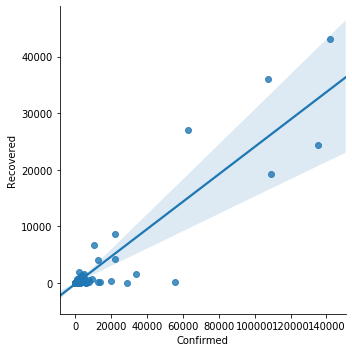

In [49]:
sns.lmplot(x="Confirmed", y="Recovered", data=temp_file_f);

# Regression en utilisant scikit-learn

In [50]:
X = temp_file_f[["Confirmed"]]
y = temp_file_f["Deaths"]

# On fit le modele
model = linear_model.LinearRegression()
results = model.fit(X, y)

In [51]:
print(results.intercept_, results.coef_)

-100.5508159530379 [0.08864665]


# Regression en utilisant statsmodels

In [52]:
model = sm.OLS(y, X)
results = model.fit()
# Avec  statsmodel, on a une sortie qui ressemble beaucoup à celle de R
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Deaths   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Method:                 Least Squares   F-statistic:                              985.4
Date:                Wed, 08 Apr 2020   Prob (F-statistic):                    1.37e-75
Time:                        20:18:21   Log-Likelihood:                         -1479.9
No. Observations:                 184   AIC:                                      2962.
Df Residuals:                     183   BIC:                                      2965.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [53]:
 #https://pandas.pydata.org/pandas-docs/version/0.15/visualization.html
def location(row):
    if row['Country/Region']=='China':
        if row['Province/State']=='Hubei':
            return 'Hubei'
        else:
            return 'Chine'
    else:
        return 'Le reste du monde'

temp_file = df.copy()
temp_file['Region'] = temp_file.apply(location, axis=1)
#temp_file['Date'] = temp_file['Date'].dt.strftime('%Y-%m-%d')
temp_file = temp_file.groupby(['Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
temp_file = temp_file.melt(id_vars=['Region', 'Date'], value_vars=['Confirmed', 'Deaths', 'Recovered'], 
                 var_name='Cas', value_name='Nombres').sort_values('Nombres')
# temp_file = temp_file.sort_values(['Date', 'Region', 'Case']).reset_index()
temp_file.head()

fig = px.bar(temp_file, y='Region', x='Nombres', color='Cas', barmode='group', orientation='h',
             text='Nombres', title='Hubei - Chine - Monde', animation_frame='Date',
             color_discrete_sequence= [d, r, c], range_x=[0, 500000])
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(yaxis={'categoryorder':'array', 
                         'categoryarray':['Hubei','Chine','Le reste du monde']})
fig.write_html("Cas_Compare.html")

In [54]:
#https://medium.com/@kbrook10/day-8-data-visualization-how-to-use-choropleth-maps-63c0fedfd5e7
#https://plot.ly/python/plotly-express/
formated_gdf = df.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2], 
                     projection="natural earth", animation_frame="Date", 
                     title='Vue globale par date')
fig.update(layout_coloraxis_showscale=False)
fig.write_html("Globe.html")

In [55]:
# https://plot.ly/python/choropleth-maps/
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1)

for i in range(0, len(df)):
    folium.Circle(
        location=[df.iloc[i]['Lat'], df.iloc[i]['Long']],
        color='blue', 
        tooltip =   '<li><bold>Country : '+str(df.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(df.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(df.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(df.iloc[i]['Deaths'])+
                    '<li><bold>Recovered : '+str(df.iloc[i]['Recovered']),
        radius=int(df.iloc[i]['Confirmed'])**1.1).add_to(m)
m
m.save('Covidp.html')

In [56]:
temp = df.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()
temp = temp.reset_index()
# temp.head()

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region', orientation='v', height=600,
             title='Confirmed', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.write_html("Confirmed.html")

fig = px.bar(temp, x="Date", y="Deaths", color='Country/Region', orientation='v', height=600,
             title='Deaths', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.write_html("Deaths.html")

In [57]:
temp = df.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region',
             title='Nombre de cas par jours')
fig.write_html("Nombre_de_cas_par_jours.html")

fig = px.bar(temp[temp['Country/Region']!='China'], x="Date", y="Confirmed", color='Country/Region',
             title='Nombre de nouveau cas hors chine')
fig.write_html("Nombre_de_nouveau_cas_hors_chine.html")

fig = px.bar(temp, x="Date", y="Deaths", color='Country/Region',
             title='Nombre de nouveau Mort hors chine')
fig.write_html("Nombre_de_nouveau_Mort_hors_chine.html")

In [58]:
fig=px.line(temp, x="Date", y="Confirmed", color='Country/Region', title='Cases Spread', height=600)
fig.write_html("test.html")

In [59]:
df_france=df.loc[df['Country/Region'] == 'France']
temp = df_france.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered','toujours infecté']
temp = temp.sum().diff().reset_index()

df_italy=df.loc[df['Country/Region'] == 'Italy']
temp = df_italy.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered','toujours infecté']
temp = temp.sum().diff().reset_index()

df_germany=df.loc[df['Country/Region'] == 'Germany']
temp = df_germany.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered','toujours infecté']
temp = temp.sum().diff().reset_index()

df_Belgium=df.loc[df['Country/Region'] == 'Belgium']
temp = df_Belgium.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered','toujours infecté']
temp = temp.sum().diff().reset_index()

frames = [df_france, df_italy,df_germany,df_Belgium]
result = pd.concat(frames)

In [60]:
import plotly.express as px
fig=px.line(result, x='Date', y='Confirmed', color='Country/Region' ,
           title="Evolution des cas en Europe")
           
fig.write_html("Evol_Cas_Europe.html")

In [61]:
fig=px.line(result, x='Date', y='Deaths', color='Country/Region',
           title="Evolution des décès en Europe")
           
fig.write_html("Evol_Deaths_Europe.html")

In [62]:
import plotly.express as px
fig = px.scatter(result, x="Date", y="Confirmed", color="Country/Region",
                 title="Evolution des cas en Europe")

fig.write_html("Evol_Monde.html")

In [63]:
df=result

In [64]:
import plotly.express as px

fig = px.scatter(df, x="Confirmed", y="Deaths", color="Country/Region", marginal_y="violin",
           marginal_x="box", trendline="ols", title='nuage de points')
fig.write_html('Evol_Deaths_Europe.html')

In [65]:
import plotly.express as px
fig = px.scatter(df, x="Confirmed", y="Deaths", color="Country/Region", facet_col="Country/Region",
           color_continuous_scale=px.colors.sequential.Viridis, render_mode="webgl")
fig.write_html('scatter_europeByCountry.html')

In [66]:
import plotly.express as px
fig = px.scatter(df, x="Confirmed", y="Deaths", size="Deaths",title='nuage de points taille par nombres de décès', color="Country/Region",
           hover_name="Country/Region", log_x=True, size_max=60)
fig.write_html('scatter_europe.html')

In [67]:
import plotly.express as px
fig = px.strip(df, x="Confirmed", y="Country/Region", orientation="h", color="Country/Region")
fig.write_html('Evol_Cas_Europe.html')